# Grover’s Search and Quantum Counting — Notebook

Course: Quantum Computing PHYS-541 (2025–2026)

Authors / Helpers: Vincenzo Savona (teacher), Sara Alves dos Santos, David Linteau, Shao Chiew (assistants)

---

This notebook is designed to fully address Project 6: Grover and quantum counting. It mixes theoretical exposition, worked derivations, and runnable Qiskit code cells to perform experiments (oracles, Grover iterations, phase estimation / quantum counting, noise simulations, and analysis).

Note: Run the code cells in an environment with qiskit and qiskit-aer installed. Use Python 3.11+. If you want to install the dependencies, run : `pip install -r requirements.txt`, we work with `qiskit:2.2.3`

In [20]:
import math
import sys
import os

from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Importing functions present in `src/` :

In [21]:
sys.path.append(os.path.abspath('./src'))
from grover_circuit import grover_circuit
from quantum_counting import quantum_counting
from utils import counts_to_m
from quantum_counting_nosie import quantum_counting_nosie

---

Table of contents: 
1.	Theory: Grover’s algorithm (derivation, geometric picture, Grover angle \theta)
2.	Quantum counting: phase estimation on the Grover operator and recovering m
3.	Complexity discussion: Grover in the landscape of quantum complexity and limits for NP problems
4.	Implementation in Qiskit (Utilities, Oracle builders (ancilla-based and ancilla-free), Diffusion (inversion-about-average), Grover iteration and runner, Quantum counting (phase estimation) implementation)
5.	Noise simulations and experiments (Aer noise model (depolarizing, amplitude damping), Parameter sweeps (n, m, noise strength))
6.	Analysis and figures
7.	Suggested experiments and questions to discuss in the report

---

## 1. Theory — Grover’s algorithm (short, self-contained)

Problem setup. Database of size $N=2^n$. A boolean function $f:\{0,1\}^n\to\{0,1\}$ marks m solutions where $f(x)=1$. Grover’s algorithm amplify the amplitude of marked states so that measuring yields a marked state with high probability in $\mathcal{O}(\sqrt{N/m})$ iterations.

Key steps: prepare uniform superposition $|s\rangle=\frac{1}{\sqrt{N}}\sum_x|x\rangle$, apply the Grover operator $G=U_s U_f$ where $U_f$ flips phase on marked states (oracle) and $U_s=2|s\rangle\langle s|-I$ is inversion about the mean.

Geometric picture. The state evolves in a two-dimensional subspace spanned by the normalized marked-state superposition $|\alpha\rangle$ and the normalized unmarked-state superposition $|\beta\rangle$. The initial angle $\theta/2$ satisfies $\sin(\theta/2)=\sqrt{m/N}$. Each application of G rotates the state by angle $\theta$. After $r$ iterations the success probability is $\sin^2((2r+1)\theta/2)$. Optimal number of iterations is approximately $r\approx\left\lfloor\frac{\pi}{4}\sqrt{N/m}\right\rfloor$.

(Include derivation steps in a cell for the notebook where you expand the 2D rotation algebra and show how G acts as rotation by $\theta$.)

---

## 2. Quantum counting

Idea. The Grover operator $G$ has eigenvalues $e^{\pm i\theta}$ in the two-dimensional subspace. Applying phase estimation on $G$ allows us to estimate $\theta$ (or multiples), and from $\theta$ recover $m$ using $m = N\sin^2(\theta/2)$.

Phase-estimation details. Use a control register of $t$ qubits to estimate the phase to $t$ bits of precision. Controlled powers $G^{2^j}$ are required. After inverse QFT and measurement, convert measured phase $\phi$ to $\theta$ (mind branch sign and wrapping) and estimate $m$.

(Include derivation and algorithmic steps in the notebook.)

---


## 3. Complexity and importance

Write a short section discussing:
1. Grover provides a quadratic speedup $\mathcal{O}(\sqrt{N})$ vs classical $\mathcal{O}(N)$ search.
2. It is proven optimal for the unstructured search problem (lower bounds by Bennett et al.).
3. Implications for NP problems: Grover provides at most quadratic speedup for brute-force search; doesn’t collapse NP to BQP. Discuss consequences for cryptography (symmetric-key, e.g. doubling key length to resist Grover).

(Expand with references: Nielsen & Chuang, Grover’s original paper, Brassard et al.)

---

## 4. Implementation in Qiskit 

In [22]:
n = 3                  # number of qubits
targets = ["111"]      # target states
iterations = 100       # number of Grover iterations
ancilla_qubits = 1     # number of ancilla qubits for counting
t_bits = 3             # number of counting qubits

In [23]:
qc, probs = grover_circuit(n, targets, iterations)

print("Probabilities at each iteration:", probs)
#qc.draw('mpl')

Probabilities at each iteration: [np.float64(0.12499999999999978), np.float64(0.12499999999999963), np.float64(0.12499999999999947), np.float64(0.1249999999999993), np.float64(0.12499999999999915), np.float64(0.124999999999999), np.float64(0.12499999999999883), np.float64(0.12499999999999868), np.float64(0.12499999999999853), np.float64(0.12499999999999836), np.float64(0.12499999999999821), np.float64(0.12499999999999806), np.float64(0.12499999999999789), np.float64(0.12499999999999774), np.float64(0.1249999999999975), np.float64(0.12499999999999739), np.float64(0.12499999999999722), np.float64(0.12499999999999699), np.float64(0.1249999999999968), np.float64(0.1249999999999966), np.float64(0.1249999999999964), np.float64(0.12499999999999621), np.float64(0.12499999999999602), np.float64(0.12499999999999582), np.float64(0.12499999999999561), np.float64(0.12499999999999546), np.float64(0.12499999999999527), np.float64(0.12499999999999512), np.float64(0.12499999999999495), np.float64(0.124

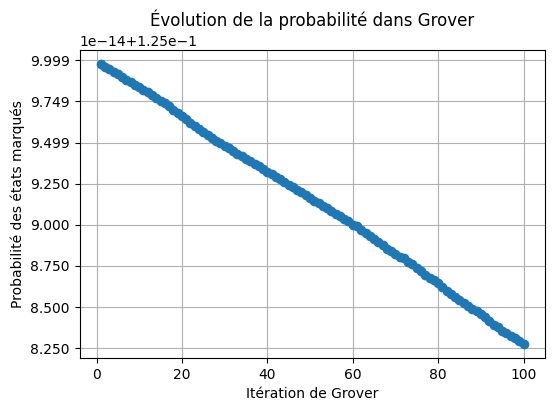

In [24]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(probs)+1), probs, marker='o')
plt.xlabel("Itération de Grover")
plt.ylabel("Probabilité des états marqués")
plt.title("Évolution de la probabilité dans Grover")
plt.grid(True)
plt.show()

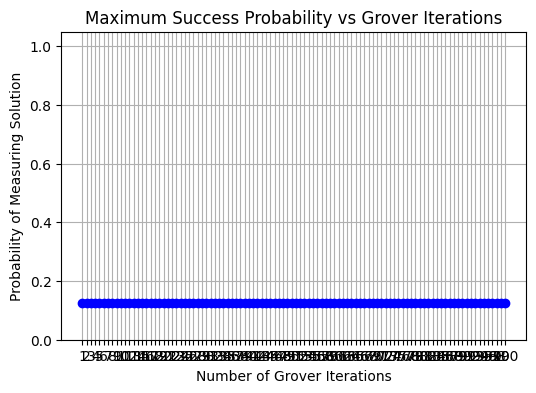

In [25]:
iterations = range(1, len(probs) + 1)

plt.figure(figsize=(6,4))
plt.plot(iterations, probs, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of Grover Iterations")
plt.ylabel("Probability of Measuring Solution")
plt.title("Maximum Success Probability vs Grover Iterations")
plt.grid(True)
plt.xticks(iterations)  # show all iteration numbers
plt.ylim(0, 1.05)       # probability goes from 0 to 1
plt.show()

---

## 5. Quantum Counting (Phase Estimation on the Grover operator)

{'001': 2048}


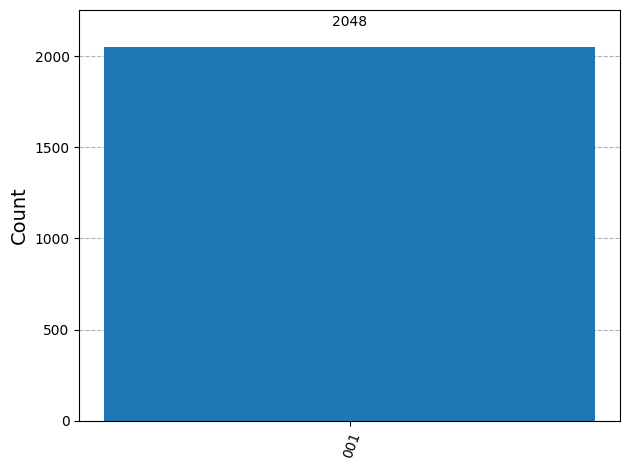

In [26]:
counts = quantum_counting(n, targets, t_bits = n)
plot_histogram(counts)
print(counts)

In [27]:
counts = quantum_counting(n, targets, t_bits)

m_est, measured_bin, phi = counts_to_m(counts, n, t_bits)
print(f"Most frequent measurement (counting qubits): {measured_bin}")
print(f"Phase estimate φ = {phi:.4f}, estimated θ = {2*np.pi*phi:.4f}")
print(f"Estimated number of marked items m ≈ {m_est:.2f}")

Most frequent measurement (counting qubits): 001
Phase estimate φ = 0.1250, estimated θ = 0.7854
Estimated number of marked items m ≈ 1.17


---

## 6. Noise Models & Simulation

{'101': 217, '111': 36, '011': 128, '000': 173, '010': 151, '100': 47, '110': 219, '001': 3029}


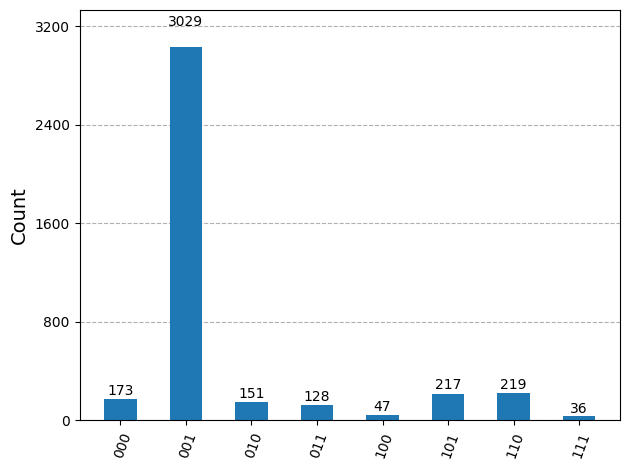

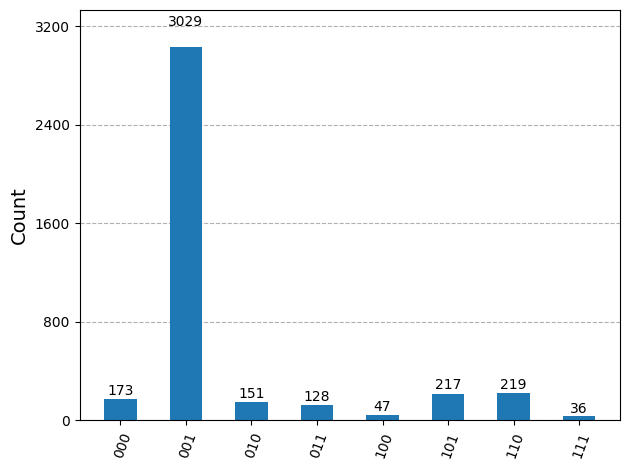

In [28]:
# Example usage for 2 solutions with noise
n = 3                            # number of qubits
targets = ['011','101']          # the two marked solutions
counts = quantum_counting_nosie(n, targets, t_bits=3, noisy=True)
print(counts)
plot_histogram(counts)

---

## 7. Analysis & Plots